## Preparation of aerial photographs

The part of the code for preparing aerial photographs was used from https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68

Let’s open the .jp2 file

In [40]:
import rasterio

raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'

with rasterio.open(raster_path, 'r', driver='JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

Viewing the image

In [41]:
from rasterio.plot import reshape_as_image
raster_img = reshape_as_image(raster_img)

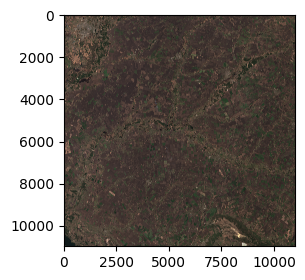

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.imshow(raster_img)

Let's take a look at the labels

In [43]:
import geopandas as gpd

train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head()

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


Let's add missing indexes. Before that, let's keep only those rows that have values in the 'geometry' field.

In [44]:
train_df = train_df[train_df.geometry.notnull()]
index = [i for i in range(0,935,1)]
train_df['id'] = index

Let's take one of the points of the Polygon

In [45]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

Using http://projfinder.com/, we found a suitable EPSG based on the coordinates. EPSG:4267

In [46]:
train_df.crs = ('epsg:4267')
train_df = train_df.to_crs(raster_meta['crs']['init'])

Let's perform a check of data masking

In [48]:
from rasterio.mask import mask
from shapely.geometry import mapping

raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'

src = rasterio.open(raster_path, 'r', driver='JP2OpenJPEG')
failed = []

for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


Unfortunately, I was unable to mask all of the data

## Creating a dataset for semantic segmentation

Preparing data for semantic segmentation. Convert vector polygons to rasters

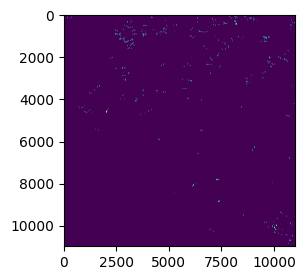

In [49]:
from shapely.ops import cascaded_union, unary_union
import numpy as np 
from shapely.geometry import mapping, Point, Polygon
from rasterio.features import rasterize


def poly_from_utm(polygon, transform):
    poly_pts = []
    
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        poly_pts.append(~transform * tuple(i))
        
    new_poly = Polygon(poly_pts)
    return new_poly


poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

plt.figure(figsize=(3,3))
plt.imshow(mask)


Let's save the resulting mask

In [50]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("mask/train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

"Cut" the mask into fields

In [51]:
raster_path = 'mask/train.jp2'

with rasterio.open(raster_path, 'r', driver='JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

In [52]:
raster_img = reshape_as_image(raster_img)

In [53]:
from rasterio.mask import mask

raster_path = 'masks/train.jp2'
src = rasterio.open(raster_path, 'r')
outfolder = "data/data/masks"

failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        masked_image = reshape_as_image(masked_image)
        mask_path = os.path.join(outfolder, str(row['id']) + '.png')
        cv2.imwrite(mask_path, masked_image)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


"Cut" the image into fields

In [54]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'

src = rasterio.open(raster_path, 'r', driver='JP2OpenJPEG')
outfolder = "data/data/images"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = mask(src, [mapping(row['geometry'])], filled=False, crop=True)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        # print(e)
        failed.append(num)

print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


We have created a dataset with images and masks, but they are of different sizes. It is assumed that for semantic segmentation, a neural network with the U-Net architecture will be used, which requires images of the same size as input

We will resize the images and masks to the size of (128, 128)

In [55]:
import cv2
from PIL import Image

inPath = 'data\data\masks'
  
outPath = 'data\resized_data\masks'
  
for imagePath in os.listdir(inPath):
    if (imagePath.endswith(".png")):
        inputPath = os.path.join(inPath, imagePath) 
        
        img = Image.open(inputPath)
        
        fullOutPath = os.path.join(outPath, imagePath)

        img_nn_pil = np.array(img.resize((128, 128), Image.NEAREST))
        cv2.imwrite(fullOutPath, img_nn_pil)


In [56]:
inPath = r'data\data\images'
outPath = r'data\resized_data\images'

for imagePath in os.listdir(inPath):
    if (imagePath.endswith(".png")):
        inputPath = os.path.join(inPath, imagePath) 
        
        img = Image.open(inputPath)
  
        fullOutPath = os.path.join(outPath, imagePath)

        img_nn_pil = np.array(img.resize((128, 128), Image.NEAREST))
        cv2.imwrite(fullOutPath, img_nn_pil)

Let's sort the names of the images and masks

In [57]:
import re
import glob

images_names = glob.glob("data/resized_data/images/*.png")
images_names.sort(key=lambda f: int(re.sub('\D', '', f)))
images_names

['data/resized_data/images\\0.png',
 'data/resized_data/images\\1.png',
 'data/resized_data/images\\2.png',
 'data/resized_data/images\\3.png',
 'data/resized_data/images\\4.png',
 'data/resized_data/images\\5.png',
 'data/resized_data/images\\6.png',
 'data/resized_data/images\\7.png',
 'data/resized_data/images\\8.png',
 'data/resized_data/images\\9.png',
 'data/resized_data/images\\10.png',
 'data/resized_data/images\\11.png',
 'data/resized_data/images\\15.png',
 'data/resized_data/images\\16.png',
 'data/resized_data/images\\17.png',
 'data/resized_data/images\\18.png',
 'data/resized_data/images\\19.png',
 'data/resized_data/images\\20.png',
 'data/resized_data/images\\21.png',
 'data/resized_data/images\\22.png',
 'data/resized_data/images\\23.png',
 'data/resized_data/images\\24.png',
 'data/resized_data/images\\25.png',
 'data/resized_data/images\\26.png',
 'data/resized_data/images\\27.png',
 'data/resized_data/images\\28.png',
 'data/resized_data/images\\29.png',
 'data/resi

In [58]:
masks_names = glob.glob("data/resized_data/masks/*.png")
masks_names.sort(key=lambda f: int(re.sub('\D', '', f)))
masks_names

['data/resized_data/masks\\0.png',
 'data/resized_data/masks\\1.png',
 'data/resized_data/masks\\2.png',
 'data/resized_data/masks\\3.png',
 'data/resized_data/masks\\4.png',
 'data/resized_data/masks\\5.png',
 'data/resized_data/masks\\6.png',
 'data/resized_data/masks\\7.png',
 'data/resized_data/masks\\8.png',
 'data/resized_data/masks\\9.png',
 'data/resized_data/masks\\10.png',
 'data/resized_data/masks\\11.png',
 'data/resized_data/masks\\15.png',
 'data/resized_data/masks\\16.png',
 'data/resized_data/masks\\17.png',
 'data/resized_data/masks\\18.png',
 'data/resized_data/masks\\19.png',
 'data/resized_data/masks\\20.png',
 'data/resized_data/masks\\21.png',
 'data/resized_data/masks\\22.png',
 'data/resized_data/masks\\23.png',
 'data/resized_data/masks\\24.png',
 'data/resized_data/masks\\25.png',
 'data/resized_data/masks\\26.png',
 'data/resized_data/masks\\27.png',
 'data/resized_data/masks\\28.png',
 'data/resized_data/masks\\29.png',
 'data/resized_data/masks\\30.png',
 '

Extract images by file names

In [59]:
images = [cv2.imread(img) for img in images_names]
images_dataset = np.array(images)
images_dataset.shape

(500, 128, 128, 3)

In [60]:
masks = []
for mask in masks_names:
    gray = cv2.imread(mask,0)
    ret,thresh = cv2.threshold(gray,70,255,0)
    masks.append(thresh)

masks_dataset = np.array(masks)
masks_dataset = np.expand_dims(masks_dataset, axis=-1)
masks_dataset.shape

(500, 128, 128, 1)

Data augmentation

In [61]:
import tensorflow as tf

X_augmented = []
Y_augmented = []
def augment(input_image, input_mask):
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

for i in range(500):
    x, y = augment(images_dataset[i], masks_dataset[i])
    X_augmented.append(x)
    Y_augmented.append(y)

In [62]:
X = np.concatenate((images_dataset, X_augmented), axis = 0)
y = np.concatenate((masks_dataset, Y_augmented), axis = 0)

Data normalization

In [66]:
X.max()

197

In [67]:
np.unique(y)

array([  0, 255], dtype=uint8)

In [68]:
X = X / X.max()
y = y / y.max()

In [69]:
X.max()

1.0

In [71]:
np.unique(y)

array([0., 1.])

Let's form test, train, and validation sets

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Model U-Net

In [94]:
inputs = tf.keras.layers.Input((128, 128, 3))

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [112]:
checkpoint_filepath = 'model_unet'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Training the model

In [113]:
results = model.fit(X_train, y_train, batch_size=15, epochs=30, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback])

Epoch 1/30
60/60 [==============================] - 168s 3s/step - loss: 0.4864 - accuracy: 0.7639 - val_loss: 0.5379 - val_accuracy: 0.7234
Epoch 2/30
60/60 [==============================] - 155s 3s/step - loss: 0.4835 - accuracy: 0.7677 - val_loss: 0.5334 - val_accuracy: 0.7211
Epoch 3/30
60/60 [==============================] - 177s 3s/step - loss: 0.4685 - accuracy: 0.7772 - val_loss: 0.5192 - val_accuracy: 0.7422
Epoch 4/30
60/60 [==============================] - 156s 3s/step - loss: 0.4609 - accuracy: 0.7800 - val_loss: 0.5123 - val_accuracy: 0.7465
Epoch 5/30
60/60 [==============================] - 154s 3s/step - loss: 0.4492 - accuracy: 0.7864 - val_loss: 0.5261 - val_accuracy: 0.7439
Epoch 6/30
60/60 [==============================] - 164s 3s/step - loss: 0.4529 - accuracy: 0.7851 - val_loss: 0.5400 - val_accuracy: 0.7358
Epoch 7/30
60/60 [==============================] - 154s 3s/step - loss: 0.4492 - accuracy: 0.7871 - val_loss: 0.5104 - val_accuracy: 0.7488
Epoch 8/30
60

Testing

In [121]:
preds = model.predict(X_test)

2/2 [==============================] - 2s 599ms/step


In [122]:
preds = (preds > 0.5).astype(np.uint8)

Let's output the masks. The first mask is from the dataset, and the second one is obtained with the help of the neural network.

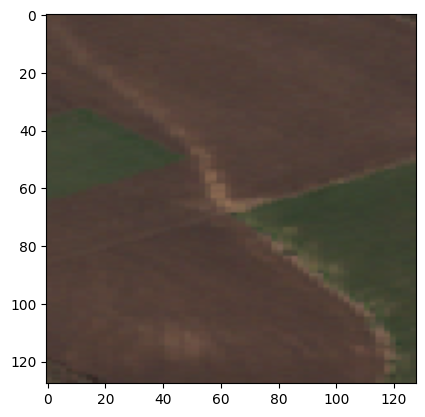

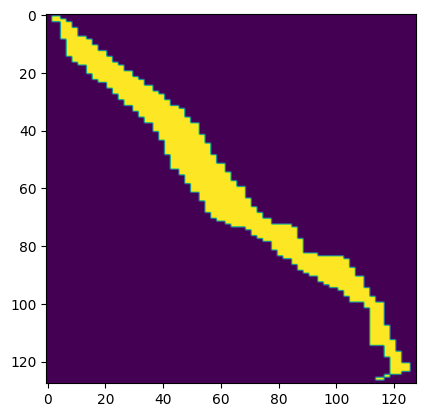

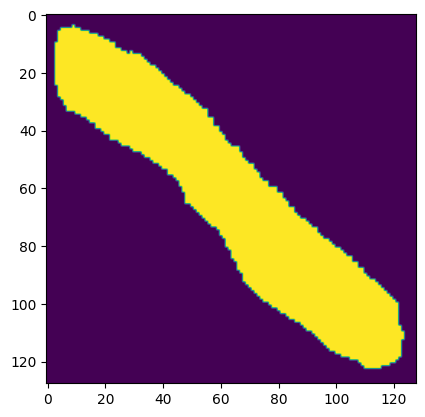

In [133]:
ix = random.randint(0, len(preds_train))
plt.imshow(X_test[ix])
plt.show()
plt.imshow(np.squeeze(y_test[ix]))
plt.show()
plt.imshow(np.squeeze(preds[ix]))
plt.show()

Evaluate the model

In [135]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 2s 577ms/step - loss: 0.4855 - accuracy: 0.7875


[0.48548585176467896, 0.7874511480331421]

Accuracy = 0.787

To improve the accuracy, it may be worth improving the quality of the images and increasing their quantity